In [ ]:
# ==============================================================================
# CÉLULA 1: INSTALAÇÃO, IMPORTAÇÕES E CONFIGURAÇÕES INICIAIS
# ==============================================================================

# --- Instalações de bibliotecas necessárias ---
!pip install spacy pandas openpyxl -q
!python -m spacy download pt_core_news_lg -q

# --- Importações Essenciais ---
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# --- Carregar o modelo de linguagem do spaCy ---
# Usamos o 'pt_core_news_lg' (large) por ser mais preciso.
try:
    nlp = spacy.load('pt_core_news_lg')
except OSError:
    print("Modelo 'pt_core_news_lg' não encontrado. Baixando agora...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "pt_core_news_lg"])
    nlp = spacy.load('pt_core_news_lg')

print("Ambiente configurado com sucesso.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Ambiente configurado com sucesso.


In [ ]:
# ==============================================================================
# CÉLULA 2: CARREGAMENTO E PREPARAÇÃO DOS DADOS DO DATALUTA
# ==============================================================================

# --- Carregamento do dataset diretamente do GitHub ---
try:
    # URL do arquivo Exemplo.xlsx no seu repositório
    raw_url = "https://raw.githubusercontent.com/abraaonazario/disciplina_IA/main/Exemplo.xlsx"

    print(f"Carregando dados de: {raw_url}")

    # Carrega o arquivo Excel, definindo a terceira linha (índice 2) como cabeçalho
    df = pd.read_excel(raw_url, header=2)

    # Seleciona as colunas de interesse e renomeia
    df = df[['Unnamed: 5', 'Unnamed: 24']].copy()
    df.rename(columns={'Unnamed: 5': 'texto', 'Unnamed: 24': 'categoria_raw'}, inplace=True)

    # Remove linhas onde o texto ou a categoria são nulos
    df.dropna(subset=['texto', 'categoria_raw'], inplace=True)

    # Processa a coluna de categoria para usar apenas o primeiro valor
    df['categoria'] = df['categoria_raw'].astype(str).apply(lambda x: x.split(';')[0].strip())

    print("Dados carregados e colunas processadas com sucesso.")
    print(f"Total de registros a serem utilizados: {len(df)}")

except Exception as e:
    print(f"Ocorreu um erro ao carregar os dados: {e}")
    df = pd.DataFrame() # Cria um dataframe vazio para evitar erros subsequentes

# --- Função de Pré-processamento com spaCy ---
def preprocess_with_spacy(text):
    doc = nlp(str(text).lower())
    lemmas = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return ' '.join(lemmas)

if not df.empty:
    print("\nIniciando pré-processamento avançado com spaCy...")
    df['texto_limpo'] = df['texto'].apply(preprocess_with_spacy)
    print("Pré-processamento concluído.")

    # --- Divisão em Treino e Teste ---
    X = df['texto_limpo']
    y = df['categoria']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # --- Vetorização com TF-IDF ---
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
else:
    print("Nenhum dado para processar.")

Carregando dados de: https://raw.githubusercontent.com/abraaonazario/disciplina_IA/main/Exemplo.xlsx
Dados carregados e colunas processadas com sucesso.
Total de registros a serem utilizados: 843

Iniciando pré-processamento avançado com spaCy...
Pré-processamento concluído.


In [ ]:
# ==============================================================================
# CÉLULA 3: TREINAMENTO DOS MODELOS DE BASE (COMPONENTES DO CHyPS)
# ==============================================================================

# --- 1. Treinamento do Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)
print("Modelo Random Forest treinado com sucesso.")

# --- 2. Configuração do LLM (Simulação Realista) ---
# SUBSTITUA ESTA FUNÇÃO PELA SUA CHAMADA DE API REAL A UM LLM
def llm_classify_simulated(text):
    text_lower = text.lower()
    if "terra" in text_lower or "territorio" in text_lower or "agrário" in text_lower:
        predicao = '15'
        confianca = np.random.uniform(0.85, 0.98)
    elif "paz" in text_lower or "violencia" in text_lower or "conflito" in text_lower:
        predicao = '16'
        confianca = np.random.uniform(0.85, 0.98)
    elif "educacao" in text_lower or "escola" in text_lower:
        predicao = '4'
        confianca = np.random.uniform(0.85, 0.98)
    else:
        # Se nenhuma palavra-chave for encontrada, a confiança é baixa
        predicao = 'NI'
        confianca = np.random.uniform(0.10, 0.30)
    return predicao, confianca

print("Função de classificação com LLM (simulada e corrigida) pronta.")

Modelo Random Forest treinado com sucesso.
Função de classificação com LLM (simulada e corrigida) pronta.


In [ ]:
# ==============================================================================
# CÉLULA 4: DEFINIÇÃO DO ALGORITMO CHyPS
# ==============================================================================

def chyps_classify(texto_original, texto_limpo, rf_model, vectorizer, limiar_tau=10):
    """
    Classificador Híbrido Ponderado para Dados Socioterritoriais (CHyPS).
    Implementa a "lógica de ponderação adaptativa" descrita no resumo.
    """
    # Predição do componente Random Forest
    texto_tfidf = vectorizer.transform([texto_limpo])
    rf_pred_proba = rf_model.predict_proba(texto_tfidf)
    confianca_rf = np.max(rf_pred_proba)
    predicao_rf = rf_model.classes_[np.argmax(rf_pred_proba)]

    # Predição do componente LLM
    predicao_llm, confianca_llm = llm_classify_simulated(texto_original)

    # Lógica de Ponderação Dinâmica
    comprimento_texto = len(texto_original.split())
    if comprimento_texto > limiar_tau:
        W_rf, W_llm = 0.3, 0.7  # Prioriza LLM para textos com mais semântica
    else:
        W_rf, W_llm = 0.7, 0.3  # Prioriza RF para textos curtos/estruturados

    # Decisão Final baseada no escore ponderado
    score_rf = confianca_rf * W_rf
    score_llm = confianca_llm * W_llm
    return predicao_llm if score_llm > score_rf else predicao_rf

print("Algoritmo CHyPS definido com sucesso.")

Algoritmo CHyPS definido com sucesso.


In [ ]:
# ==============================================================================
# CÉLULA 5: AVALIAÇÃO DOS MODELOS E COLETA DE MÉTRICAS
# ==============================================================================

resultados = []
average_type = 'weighted'

# Avaliação do Random Forest (Baseline)
y_pred_rf = rf_model.predict(X_test_tfidf)
resultados.append({
    'Modelo': 'Random Forest',
    'Acurácia': accuracy_score(y_test, y_pred_rf),
    'Precisão': precision_score(y_test, y_pred_rf, average=average_type, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf, average=average_type, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_rf, average=average_type, zero_division=0)
})

# Avaliação do CHyPS (Sua Proposta)
# É necessário ter os textos originais para a lógica de ponderação
X_test_original = df.loc[X_test.index, 'texto']
y_pred_chyps = [chyps_classify(texto_original, texto_limpo, rf_model, vectorizer)
                for texto_original, texto_limpo in zip(X_test_original, X_test)]
resultados.append({
    'Modelo': 'CHyPS',
    'Acurácia': accuracy_score(y_test, y_pred_chyps),
    'Precisão': precision_score(y_test, y_pred_chyps, average=average_type, zero_division=0),
    'Recall': recall_score(y_test, y_pred_chyps, average=average_type, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_chyps, average=average_type, zero_division=0)
})

# --- Transforma a lista de resultados em um DataFrame do Pandas ---
resultados_df = pd.DataFrame(resultados).set_index('Modelo')
print("--- Tabela Comparativa de Desempenho ---")
print(resultados_df)

--- Tabela Comparativa de Desempenho ---
               Acurácia  Precisão    Recall  F1-Score
Modelo                                               
Random Forest  0.454545  0.377136  0.454545  0.351617
CHyPS          0.399209  0.445188  0.399209  0.352539


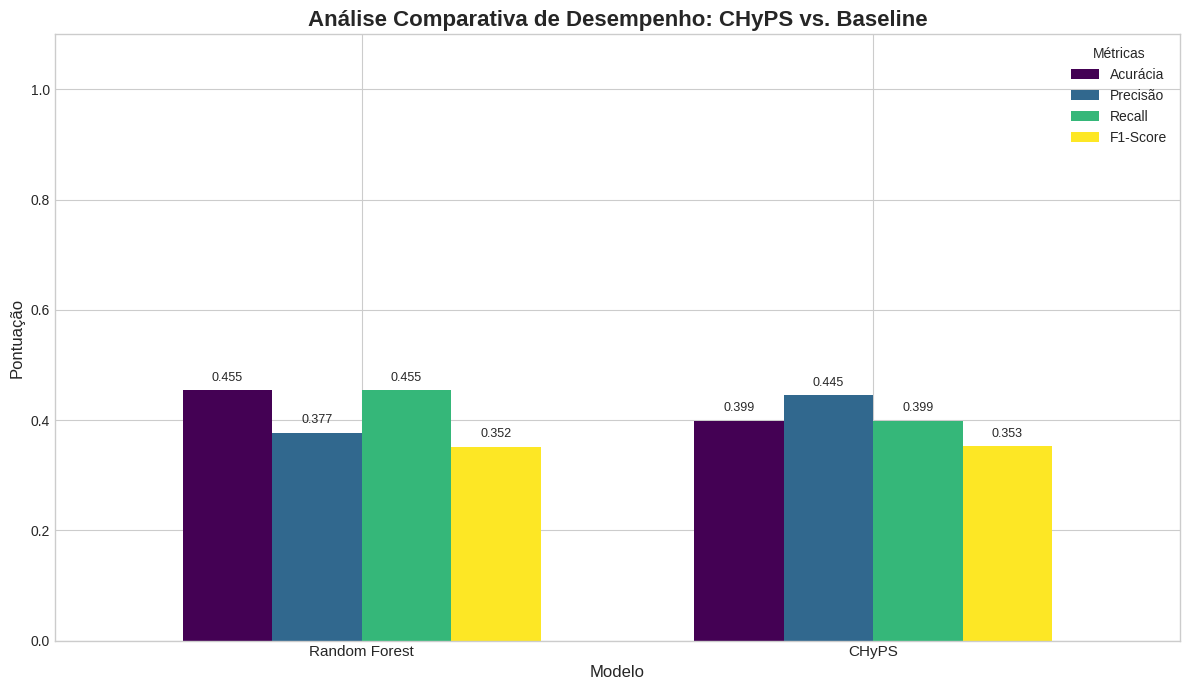

In [ ]:
# ==============================================================================
# CÉLULA 6: GERAÇÃO DO GRÁFICO COMPARATIVO
# ==============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
ax = resultados_df.plot(
    kind='bar',
    figsize=(12, 7),
    width=0.7,
    colormap='viridis'
)
plt.title('Análise Comparativa de Desempenho: CHyPS vs. Baseline', fontsize=16, weight='bold')
plt.ylabel('Pontuação', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(rotation=0, ha='center', fontsize=11)
plt.legend(title='Métricas', fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=9)
plt.tight_layout()
plt.savefig('comparacao_chyps_vs_:Random Forest (Baseline).png', dpi=300)
plt.show()